## Imports

In [14]:
import matplotlib.pyplot as plt
import numpy as np
# TODO: uncomment below for colab
#%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

## Load dataset

In [4]:
# take first 80% for train_data, last 20% for test_data
train_data, test_data = tfds.load('malaria', split=['train[:80%]', 'train[-20%:]'], as_supervised=True)

## Inspect data set

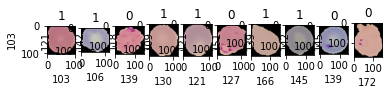

In [13]:
# TODO: how to visualize both label and shape
fig, ax = plt.subplots(1,10)
for i, (img, lbl) in enumerate(train_data):
    if i == 10:
        break
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl.numpy())
    #ax[i].set_xlabel(img.shape[0])
    #ax[i].set_ylabel(img.shape[1])
    ax[i].axis("off")

## Define some constants

In [5]:
# arbitrarily set. Feel free to change these
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

## Prepare data

In [16]:
def process_inp_and_label(input, label):
    """ resize inputs and onehotify labels """
    new_input = input / 255
    new_input = tf.image.resize(new_input, [50,50])
    return new_input, tf.one_hot(label, 2)

def data_pipeline(data):
    """ helper function for data pipeline - does all the things we need """
    data = data.map(process_inp_and_label)
    data = data.batch(BATCH_SIZE)
    data = data.shuffle(buffer_size=BATCH_SIZE)
    data = data.prefetch(PREFETCH_SIZE)
    return data

train_data = data_pipeline(train_data)
test_data = data_pipeline(test_data)

## Define helper functions

In [8]:
def train_step(model, input, target, loss_function, optimizer):
    accuracy = None

    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    accuracy = np.mean(accuracy)

    return loss, accuracy

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy


# define calc_stat here to access running_average_factor
def calc_stat(stat_so_far, new_stat, stat_num):
    """Calculates appropriate statistic

    :param stat_so_far: the statistic that we have observed so far
    :param new_stat: the newest observed statistic
    :param stat_num: new_stat is the stat_num-th observed statistic
    :return: if 0, return mean, else running average
    """

    if running_average_factor:
        return running_average_factor * stat_so_far + (1 - running_average_factor) * new_stat
    # calculate mean of observed statistics so far
    return ((stat_num - 1) * stat_so_far + new_stat) / stat_num


def plot_stats(train_stat, test_stat, stat_name):
    plt.figure()
    line1, = plt.plot(train_stat)
    line2, = plt.plot(test_stat)
    plt.xlabel("Training steps")
    plt.ylabel(stat_name)
    plt.legend((line1, line2), ("training", "test"))
    plt.show()

In [9]:
tf.keras.backend.clear_session()

##Define model

In [10]:
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons

## Prepare for training

In [11]:
num_epochs = 10
learning_rate = 0.001
# set to 0 if you want to use mean instead of running average
running_average_factor = 0.95
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

Train

In [17]:
for epoch in range(num_epochs):
    print('Epoch: ' + str(epoch))

    # shuffle train data. No need to shuffle test data
    train_data = train_data.shuffle(buffer_size=BATCH_SIZE)

    train_loss_stat = 0
    train_accuracy_stat = 0
    for i, (input, target) in enumerate(train_data):
        train_loss, train_accuracy = train_step(model, input, target, loss, optimizer)
        train_loss_stat = calc_stat(train_loss_stat, train_loss, i+1)
        train_accuracy_stat = calc_stat(train_accuracy_stat, train_accuracy, i+1)
    train_losses.append(train_loss_stat)
    train_accuracies.append(train_accuracy_stat)

    # testing
    test_loss, test_accuracy = test(model, test_data, loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

%## md Plot

%##

plot_stats(train_losses, test_losses, "Loss")
plot_stats(train_accuracies, test_accuracies, "Accuracy")

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
